# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [201]:
from pathlib import Path
import pandas
import numpy as np
import json

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

X.columns

Index(['Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'Name__other',
       'Type 1__other', 'Type 2__other', 'HP__other', 'Attack__other',
       'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other',
       'Generation__other', 'Legendary__other'],
      dtype='object')

In [202]:
def add_opposite_labels(labels):
    rt = list(labels)
    for l in labels:
        rt.append(opposite_label(l))
    return rt

def get_opposite_labels(labels):
    return [
        opposite_label(l)
        for l in labels
    ]

def opposite_label(label):
    other = '__other'
    if label.endswith(other):
        return label[:-len(other)]
    return f'{label}{other}'

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [203]:
X.dtypes

Name                  object
Type 1                object
Type 2                object
HP                   float64
Attack               float64
Defense              float64
Sp. Atk              float64
Sp. Def              float64
Speed                float64
Generation           float64
Legendary             object
Name__other           object
Type 1__other         object
Type 2__other         object
HP__other            float64
Attack__other        float64
Defense__other       float64
Sp. Atk__other       float64
Sp. Def__other       float64
Speed__other         float64
Generation__other    float64
Legendary__other      object
dtype: object

2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot: >

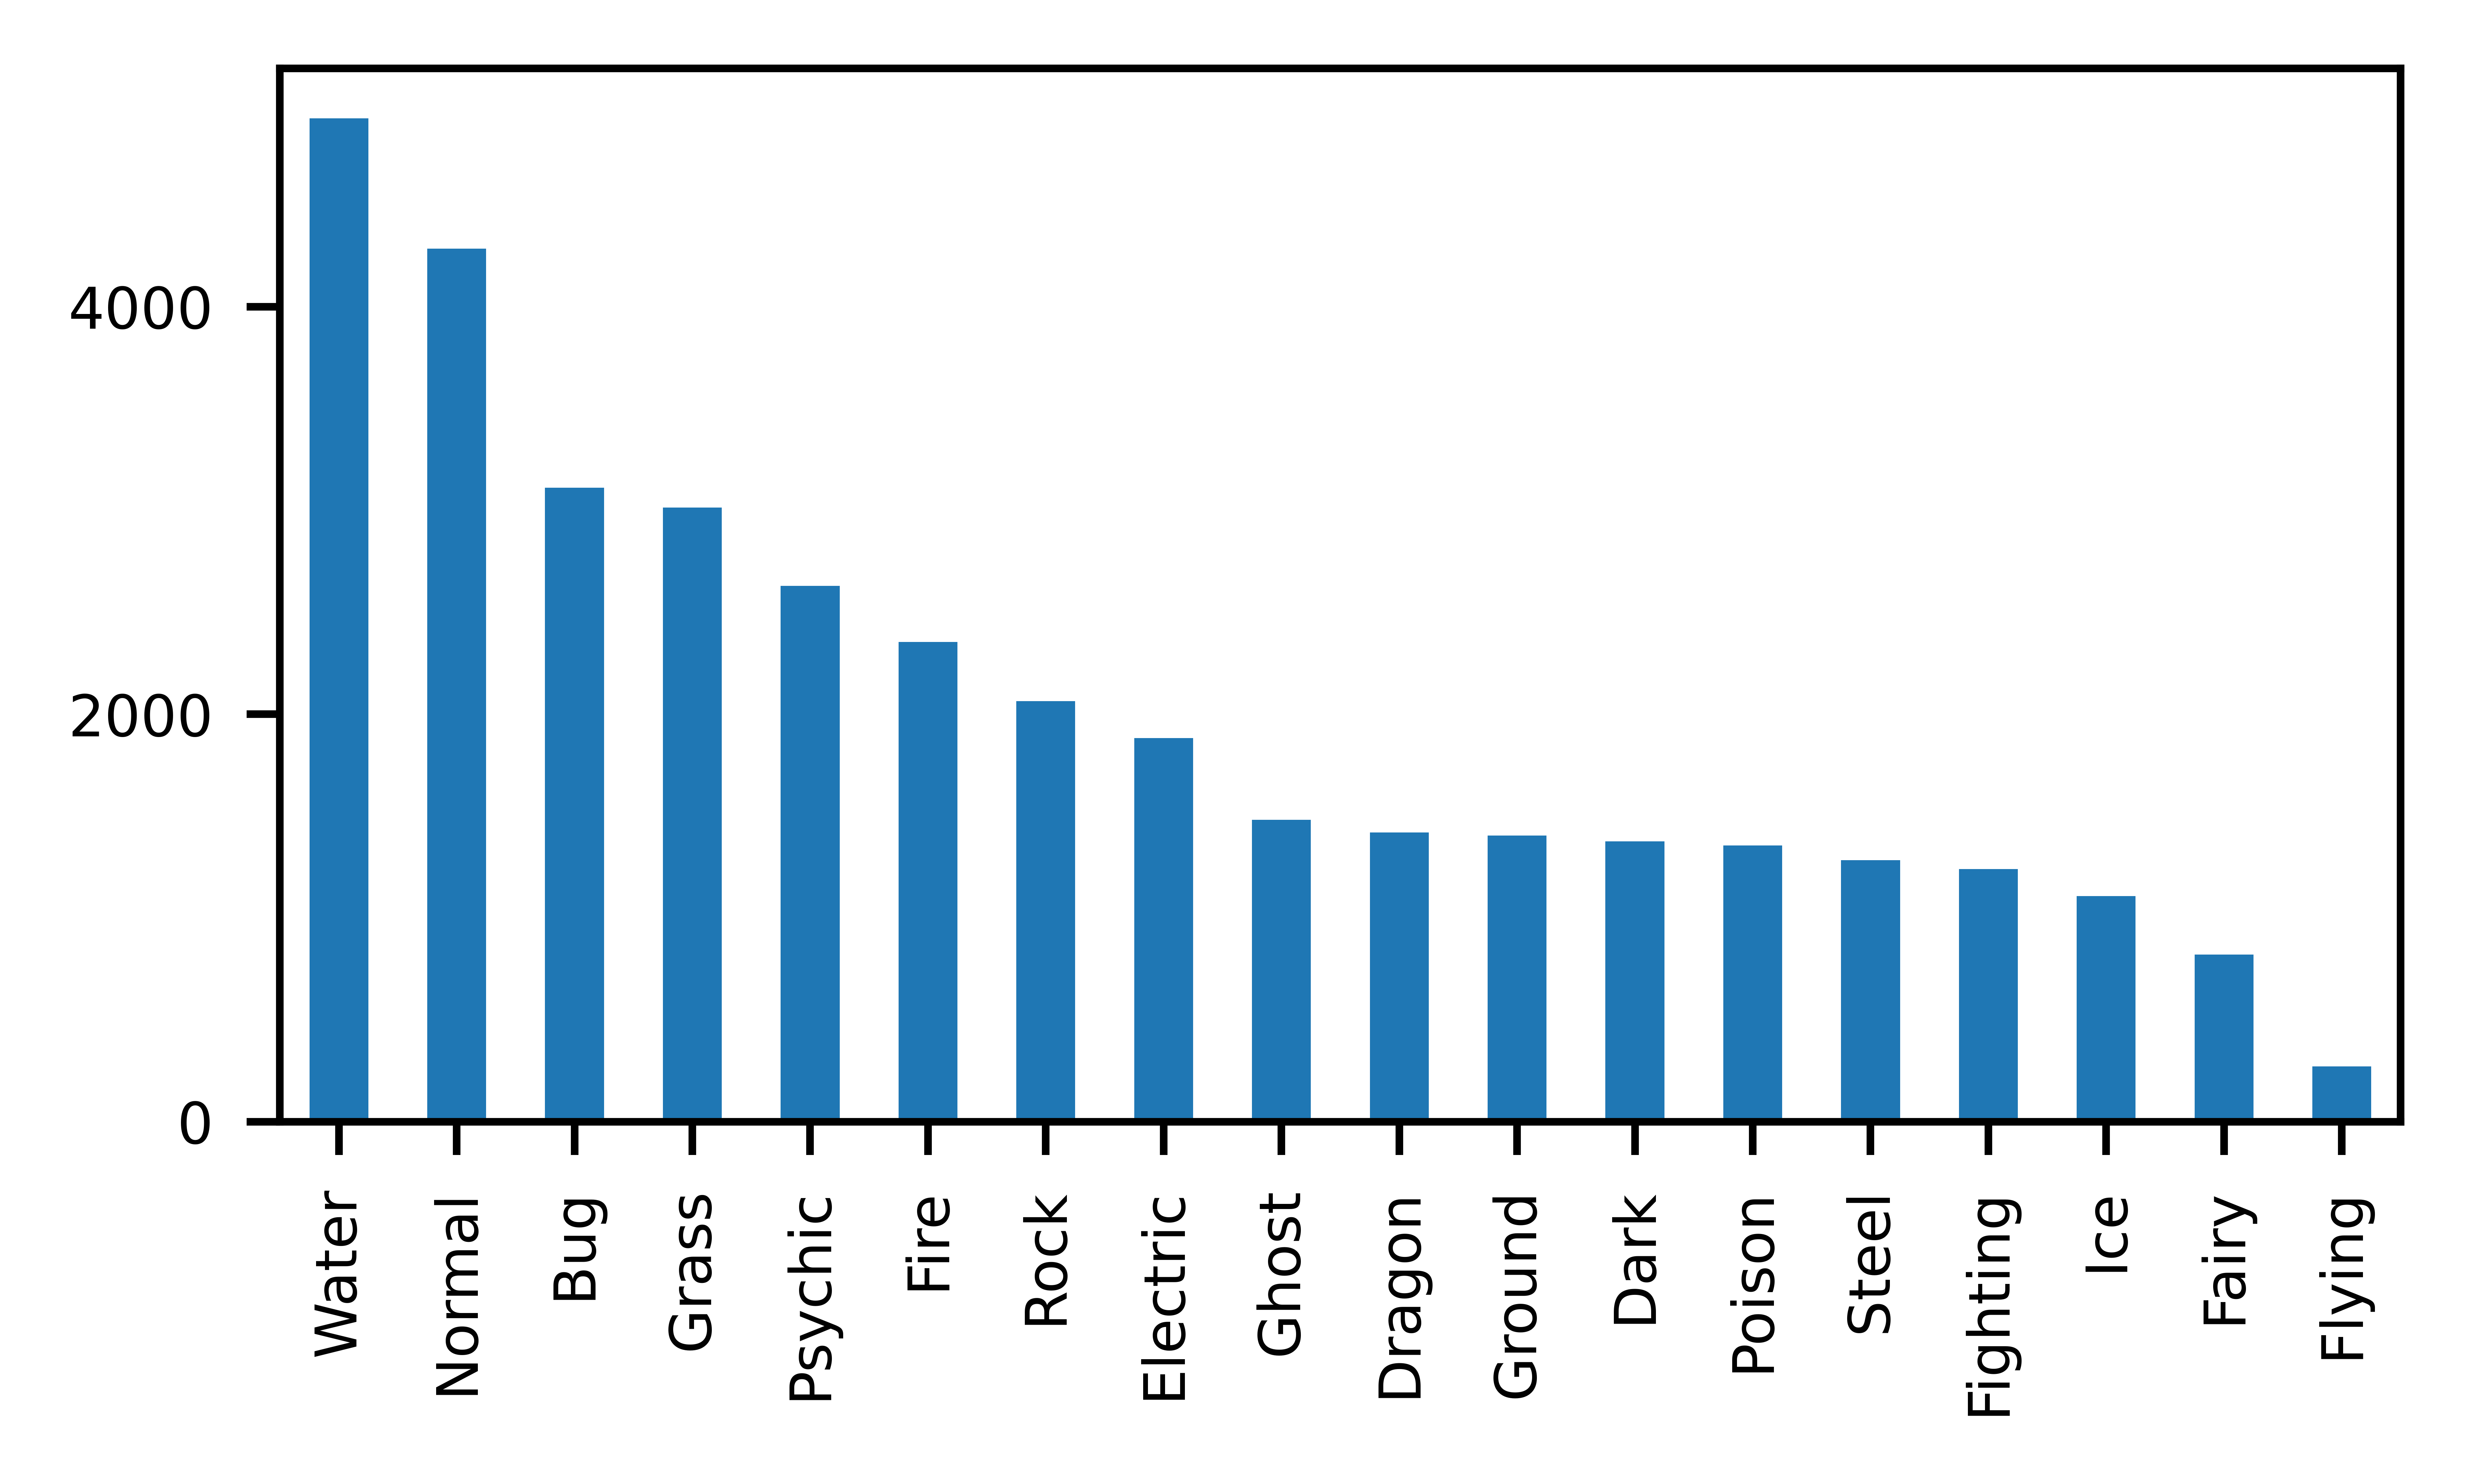

In [204]:
X['Type 1'].value_counts().plot(kind='bar', figsize=(4,2), fontsize=6)

3. Determine which of the features have missing values. How many missing values there are for each one?

In [205]:
# A lot of pokemons do NOT have Type 2, so those numbers are not representative
# We may miss some information otherwise, but we should not fill in random Type 2
# from pokemons around
# We are also ignoring Type 1 for now
# Also, we will not make up the names of the pokemons
for col in add_opposite_labels(['Name', 'Type 2', 'Type 1']):
    X[col] = X[col].fillna(value='')

X.isna().sum()
# About 4000 missing values per column

Name                    0
Type 1                  0
Type 2                  0
HP                   4006
Attack               3897
Defense              4034
Sp. Atk              3920
Sp. Def              3982
Speed                3972
Generation           3993
Legendary            3981
Name__other             0
Type 1__other           0
Type 2__other           0
HP__other            4105
Attack__other        3995
Defense__other       4016
Sp. Atk__other       4096
Sp. Def__other       4005
Speed__other         4044
Generation__other    3986
Legendary__other     3982
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

In [206]:
# Your code here...
# TODO: What is asking for here????

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

In [207]:
# Your code here...
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='distance')
columns = [
    col
    for col in X.columns if '__other' not in col
    if col not in {'Name', 'Type 1', 'Type 2'}
]

columns_other = {
    opposite_label(col): col for col in columns
}

inverse_columns_other = {
    v: k for k,v in columns_other.items()
}

first_half = X[columns]
second_half = X[get_opposite_labels(columns)]
second_half = second_half.rename(columns=columns_other)
imputer.fit(pandas.concat([first_half, second_half]))

first_half_predict = imputer.transform(first_half)
second_half_predict = imputer.transform(second_half)
X[columns] = first_half_predict
X[get_opposite_labels(columns)] = second_half_predict
X.isna().sum()

Name                 0
Type 1               0
Type 2               0
HP                   0
Attack               0
Defense              0
Sp. Atk              0
Sp. Def              0
Speed                0
Generation           0
Legendary            0
Name__other          0
Type 1__other        0
Type 2__other        0
HP__other            0
Attack__other        0
Defense__other       0
Sp. Atk__other       0
Sp. Def__other       0
Speed__other         0
Generation__other    0
Legendary__other     0
dtype: int64

In [208]:
with open('type-chart.json') as f:
    type_matrix = json.load(f)

def map_row(row, opposite):
    type_row = ['Type 1', 'Type 2']
    if opposite:
        type_row = get_opposite_labels(type_row)
    best_attack_multiplier = 0.25
    at_least_one_type = False
    for attack_type in type_row:
        attack_type = row[attack_type].lower()
        if not attack_type: continue
        multiplier = 1
        for defense_type in type_row:
            enemy_defense = defense_type if opposite else opposite_label(defense_type)
            defense_type = row[enemy_defense].lower()
            if not defense_type: continue
            multiplier *= type_matrix[attack_type][defense_type]
            at_least_one_type = True
        best_attack_multiplier = max(best_attack_multiplier, multiplier)
    if not at_least_one_type:
        return 1
    return best_attack_multiplier
            


def add_pokemon_ratio(df):
    clean_ratios = df[add_opposite_labels(['Attack', 'Defense', 'Sp. Atk', 'Sp. Def'])]
    clean_ratios = df.replace(0, 1)
    for side in [True, False]:
        ot_label = '', '__other'
        if not side:
            ot_label = ot_label[::-1]
        first_label, second_label = ot_label
        at_def_ratio = df[f'Attack{first_label}'] / clean_ratios[f'Defense{second_label}']
        sp_at_def_ratio = df[f'Sp. Atk{first_label}'] / clean_ratios[f'Sp. Def{second_label}']
        best_ratio = pandas.concat([at_def_ratio, sp_at_def_ratio], axis=1).max(axis=1)
        df[f'best_attack_ratio{first_label}'] = best_ratio

        
        df[f'is_mega{first_label}'] = df[f'Name{first_label}'].str.contains('Mega ', regex=False).astype(int)
        stat_sum = X[[f'HP{first_label}', f'Attack{first_label}' , f'Defense{first_label}' , f'Sp. Atk{first_label}' ,f'Sp. Def{first_label}' ,f'Speed{first_label}']].sum(axis=1)
        df[f'sum_stats{first_label}'] = stat_sum

    df['attack_multiplier'] = df.apply(lambda row: map_row(row, opposite=False),axis=1)
    df[opposite_label('attack_multiplier')] = df.apply(lambda row: map_row(row, opposite=True),axis=1)
    df['attack_multipler_diff'] = df['attack_multiplier'] - df[opposite_label('attack_multiplier')]
    df['HP_diff'] = df['HP'] - df[opposite_label('HP')]
    df['HP_attack'] = df['HP'] / df[opposite_label('attack_multiplier')]
    df[opposite_label('HP_attack')] = df[opposite_label('HP')] / df['attack_multiplier']

        

def add_velocity_dif(df):
    # TODO: CONTEMPLAR QUE SPEED IGUAL ES RANDOM! HAURIA DE SER 0.5!!
    df['velocity_dif'] =  (df['Speed'] >= df['Speed__other']).astype(int)

In [209]:
add_pokemon_ratio(X)
add_velocity_dif(X)

In [210]:
X

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,best_attack_ratio__other,is_mega__other,sum_stats__other,attack_multiplier,attack_multiplier__other,attack_multipler_diff,HP_diff,HP_attack,HP_attack__other,velocity_dif
39087,Karrablast,Bug,,50.000000,72.0,39.0,39.000000,42.0,55.0,5.0,...,1.358974,0,260.0,1.00,1.0,0.00,0.000000,50.000000,50.0,1
30893,,Rock,Water,70.000000,104.5,125.0,113.000000,78.0,106.5,1.0,...,0.628205,0,371.0,2.00,0.5,1.50,5.000000,140.000000,32.5,1
45278,Mega Manectric,Electric,,70.000000,77.0,81.0,118.175416,91.0,136.0,3.0,...,0.592593,0,447.5,1.00,0.5,0.50,-45.000000,140.000000,115.0,1
16398,Bouffalant,Psychic,,95.000000,121.0,73.0,39.000000,85.0,89.5,5.0,...,1.479452,0,497.0,1.00,1.0,0.00,20.000000,95.000000,75.0,0
13653,Swablu,Normal,Flying,45.000000,36.0,58.0,37.000000,76.0,56.0,3.0,...,1.421053,0,471.0,1.00,1.0,0.00,5.000000,45.000000,40.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,,Grass,Fairy,60.000000,63.0,122.0,79.000000,103.0,118.0,5.0,...,0.864078,0,412.0,2.00,0.5,1.50,5.000000,120.000000,27.5,1
44732,Skrelp,Poison,Water,50.000000,63.0,56.0,54.000000,54.0,36.0,6.0,...,1.462963,0,385.0,1.00,1.0,0.00,-15.000000,50.000000,65.0,1
38158,Florges,Fairy,,78.000000,58.0,65.0,109.000000,103.0,75.0,6.0,...,1.400000,0,538.0,1.00,1.0,0.00,-26.000000,78.000000,104.0,1
860,Pachirisu,Electric,,85.358984,43.0,67.0,55.000000,92.0,97.0,4.0,...,1.217391,0,513.0,0.25,2.0,-1.75,35.358984,42.679492,200.0,1


In [211]:
from sklearn.model_selection import train_test_split
test_size_pctg = 0.2
seed = 42

X_dropped = X.drop(add_opposite_labels(['Name', 'Type 1', 'Type 2', 'Attack', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']), axis=1)
# X_dropped = X_dropped[['attack_multiplier', opposite_label('attack_multiplier'), 'attack_multipler_diff', 'HP_diff', 'HP_attack', opposite_label('HP_attack')]]

X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=test_size_pctg, random_state=seed)

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)



from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)  # Learn std.dev and mean

new_X = scaler.transform(X_train)
# Note that the scaler will return a numpy array
new_X

(40000, 35) (32000, 19) (8000, 19)
(40000,) (32000,) (8000,)


array([[-1.90228756e+00, -1.68376041e+00, -3.41548936e-01, ...,
        -9.13128160e-01,  6.92864873e-01,  9.94515042e-01],
       [-3.87629699e-01, -5.87974089e-01, -3.41548936e-01, ...,
         5.14986080e-01,  2.58502245e-01, -1.00551521e+00],
       [ 9.37695929e-01,  3.32554847e+00, -3.41548936e-01, ...,
         1.76458604e+00, -4.28922314e-02, -1.00551521e+00],
       ...,
       [-2.74030359e-01, -4.62741367e-01, -3.41548936e-01, ...,
        -5.02545316e-01, -7.96378423e-01, -1.00551521e+00],
       [ 7.86230143e-01,  5.39120409e-01, -3.41548936e-01, ...,
        -2.70533176e-03, -6.19087554e-01,  9.94515042e-01],
       [-1.61545414e-01, -1.08890498e+00, -3.41548936e-01, ...,
        -4.49516392e-01,  8.70376886e-01,  9.94515042e-01]])

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree

model = DecisionTreeClassifier(criterion="entropy", max_depth=8, min_samples_leaf=5)
model.fit(new_X, y_train)

print("Score in train:", model.score(new_X, y_train))

Score in train: 0.8495625


In [213]:
new_X[0]

array([-1.90228756, -1.68376041, -0.34154894,  1.74184884, -0.99775199,
       -0.30903519, -0.53943635, -0.23730736, -2.13610318, -0.14730173,
       -0.24088611, -0.7309382 , -0.26028179, -0.91788469,  0.4191382 ,
       -2.57161005, -0.91312816,  0.69286487,  0.99451504])

In [214]:
tree.plot_tree(model, feature_names=list(X_train.columns), class_names=["False", "True"], proportion=True, precision=2, fontsize=4)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 2000
plt.show()

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion="entropy", max_depth=15, min_samples_leaf=5)
model.fit(new_X, y_train)

print("Score in train:", model.score(new_X, y_train))

Score in train: 0.8683125


In [216]:
X_test_prepared = scaler.transform(X_test)

print("Score in test:", model.score(X_test_prepared, y_test))

Score in test: 0.839875


## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [217]:
# Your code here...

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [218]:
# Your code here...

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [219]:
# Your code here...